In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytesseract
from PIL import Image
from scipy import signal

# Detection Demo

## Main Points
* Current Capabilities
    * Finding instances of potential objectives
    * Within each instance, able to classify:
        * Shape
        * Alphanumeric Character
            * Classifation isn'in 
        * RGB Color values of both
        
* Future Work
    * Need more details about how detailed shape descriptions need to be
            * Current code accounts for basic shapes (circles, triangles, squares), but does not account for more      
                complex shapes (elipses, semi-circles)
 


1. Detect Regions of interest (ROI)
2. Use ROI to threshold backgorund 

# 0. TODO
1) Classifcations do not detect false cases

2) Threshold searching does not ignore 0 values (Works with samples, but not robust)

# 1.Regions of Interest (ROI)

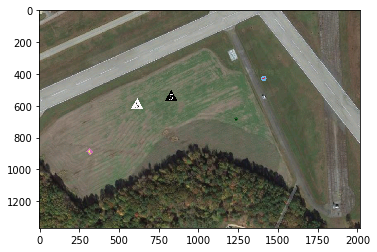

In [16]:
img_rgb = cv2.cvtColor(cv2.imread('map.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb);

In [17]:
kernel = np.ones((5,5),np.uint8)
dilated = cv2.dilate(img_rgb,kernel,iterations = 1)

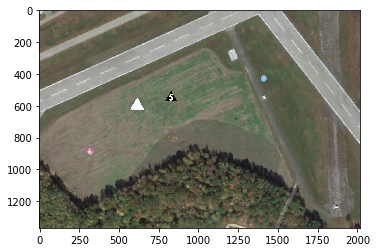

In [18]:
plt.imshow(dilated)

### 1.1 Convert RGB images to HSV
Makes it easier to separate sections of image based on hue, saturation, and value

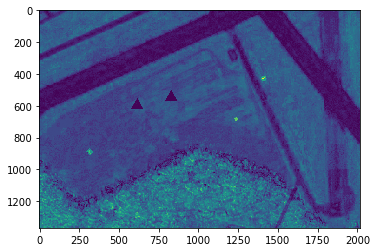

In [19]:
img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
plt.imshow(img[:,:,1]);

### 1.1.1 SURF ROI

In [20]:
SURF_HESSIAN = 3000
SURF_OCTAVES = 4
SURF_LAYERS = 2
# DIL_KERNEL_SIZE = (5,5)

In [21]:
img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
# img = img_rgb

#Dilate images to eliminate grain
kernel = np.ones(DIL_KERNEL_SIZE,np.uint8)
# img = cv2.dilate(img,kernel,iterations = 2)

# Create SURF 
surf = cv2.xfeatures2d.SURF_create(hessianThreshold=SURF_HESSIAN, nOctaves=SURF_OCTAVES, nOctaveLayers=SURF_LAYERS)
keypoints, descriptors = surf.detectAndCompute(img[:,:,0], None)
imf = cv2.drawKeypoints(im2, keypoints, None)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,4))
ax1.imshow(img)
ax1.set_title('Unprocessed HSV')
ax2.imshow(imf)
ax2.set_title('Post Dilation and SURF')
print('Keypoints found: {}'.format(len(keypoints)))

NameError: name 'DIL_KERNEL_SIZE' is not defined

In [22]:
crops = []
plt.figure(figsize=(16,8))
for i in range(len(keypoints)):
    if i > 19:
        break
    
    x,y = keypoints[i].pt      #Center of keypoint
    r = keypoints[i].size/2    #Radius of Keypoint

    crop = img_rgb[int(y-r):int(y+r), int(x-r):int(x+r)]
    crops.append(crop)
    
    plt.subplot(2,20,i+1)
    plt.imshow(crop)

NameError: name 'keypoints' is not defined

In [23]:
len(keypoints)

NameError: name 'keypoints' is not defined

In [24]:
x,y = keypoints[1].pt      #Center of keypoint
r = keypoints[1].size/2    #Radius of Keypoint

crop = img_rgb[int(y-r):int(y+r), int(x-r):int(x+r)]
plt.imshow(crop)

NameError: name 'keypoints' is not defined

In [25]:
plt.imshow(imf)

NameError: name 'imf' is not defined

In [26]:
def plot_ch(img, titles = ['Hue', 'Saturation', 'Value']):
    one = img[:,:,0]
    two = img[:,:,1]
    three = img[:,:,2] 
    
    f, axes = plt.subplots(1, 3, figsize =(20,5))
    sns.distplot(one.flatten(), ax=axes[0])
    axes[0].set_title(titles[0])
    sns.distplot(two.flatten(), ax=axes[1])
    axes[1].set_title(titles[1])
    sns.distplot(three.flatten(), ax=axes[2])
    axes[2].set_title(titles[2])

### 1.2 Visualize distribution of HSV values to determine threshold points

<img src="HSV.png" alt="Drawing" style="width: 400px;"/>

KeyboardInterrupt: 

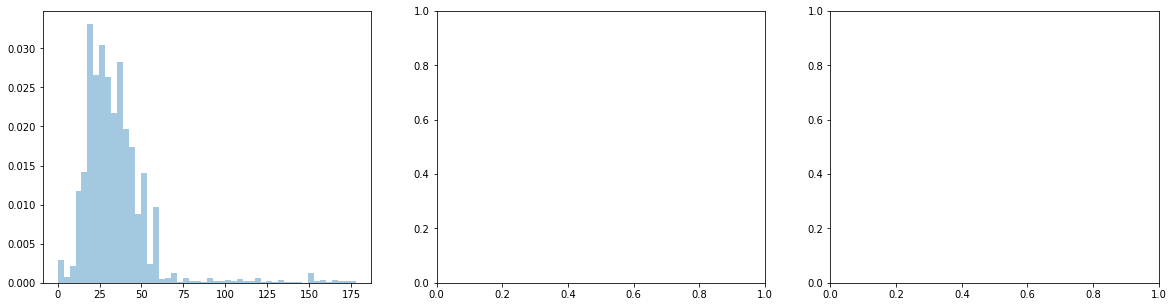

In [27]:
plot_ch(img)

### 1.3 Threshold irrelevant portions of image
Making assumption that objective points contrast colors of background, or at least that the shape does.

In [28]:
img = cv2.cvtColor(img_rgb,cv2.COLOR_RGB2HSV)
mask = cv2.inRange(img,(2,100,150),(257,257,257))  # Threshold arbirarily chosen based on dull background
mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)

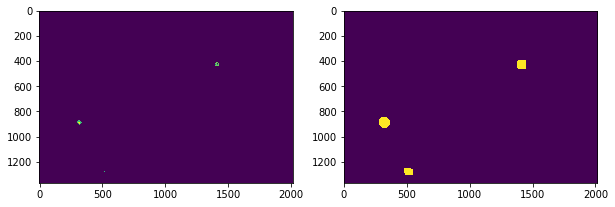

In [29]:
filtered = mask & img
f, ax = plt.subplots(1,2, figsize=(10,5))
rgb_filtered = cv2.cvtColor(filtered,cv2.COLOR_HSV2RGB)
bi_threshed = cv2.cvtColor(rgb_filtered,cv2.COLOR_RGB2GRAY)

#Dilate
kernel = np.ones((5,5),np.uint8)
dilated = cv2.dilate(bi_threshed,kernel,iterations = 10)
ret,thresh1 = cv2.threshold(dilated,2,255,cv2.THRESH_BINARY)

ax[0].imshow(bi_threshed)
ax[1].imshow(thresh1);

### 1.4 Use Blob Detector to localize ROI

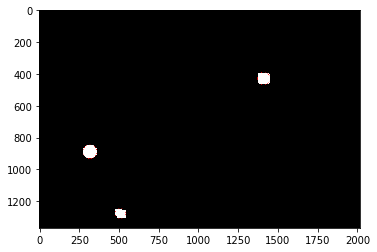

In [30]:
def find_blobs(mask):
    """Return keypoints of blobs from a binary image"""
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()


    # Change thresholds
    params.minThreshold = 10;    # the graylevel of images
    params.maxThreshold = 200;

    params.filterByColor = True
    params.blobColor = 255

    # Filter by Area
    params.filterByArea = False
    params.minArea = 10000

    params.filterByInertia = False
    params.filterByConvexity = False

    # Set up the detector with default parameters.
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs.
    keypoints = detector.detect(mask)

    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(mask, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show keypoints
    # cv2.imshow("Keypoints", im_with_keypoints)
    plt.imshow(im_with_keypoints)
    
    return keypoints

keypoints = find_blobs(thresh1)

In [31]:
#Plot keypoints

kp = 3

x,y = keypoints[kp].pt      #Center of keypoint
r = keypoints[kp].size/2    #Radius of Keypoint

crop = img_rgb[int(y-r):int(y+r), int(x-r):int(x+r)]
plt.imshow(crop)

IndexError: list index out of range

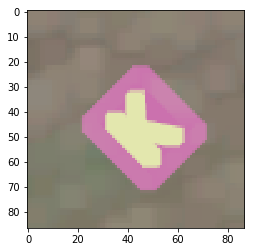

In [32]:
kp = 1

x,y = keypoints[kp].pt      #Center of keypoint
r = keypoints[kp].size/2    #Radius of Keypoint

crop = img_rgb[int(y-r):int(y+r), int(x-r):int(x+r)]


kernel = np.ones((2,2),np.uint8)
crop = cv2.dilate(crop,kernel,iterations = 5)


plt.imshow(crop)

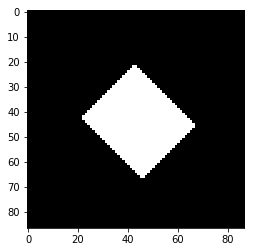

In [40]:
#Plot keypoints
kp = 1

x,y = keypoints[kp].pt      #Center of keypoint
r = keypoints[kp].size/2    #Radius of Keypoint

crop = img_rgb[int(y-r):int(y+r), int(x-r):int(x+r)]

crop = cv2.cvtColor(crop, cv2.COLOR_RGB2HSV)
crop_img = cv2.bilateralFilter(crop,100,20,20)  # Smooth image colors

hue,sat,val = find_threshhold(crop)

mask = cv2.inRange(crop_img,(0,np.mean(sat), np.mean(val)),(255,255,255))
mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR) 



plt.imshow(mask)

In [41]:
## TODO
def find_threshhold(hsv, width=5):
    
    def find_mean_dist(ch):
        """ Find the distribution of pixel frequencies and find distribution means"""
        channel = hsv[:,:,ch]
        unique, cnt = np.unique(channel, return_counts=True)
        peaks = signal.find_peaks_cwt(cnt, np.arange(1,width))
        p_args = cnt[peaks].argsort()[-2:][::-1]
        return unique[peaks[p_args]]
        
#         counts[]
    
    hue = find_mean_dist(0)
    sat = find_mean_dist(1)
    val = find_mean_dist(2)

    return (hue, sat, val)
    
    
    

In [42]:
find_threshhold(crop)

(array([ 18, 160], dtype=uint8),
 array([48, 49], dtype=uint8),
 array([124, 133], dtype=uint8))

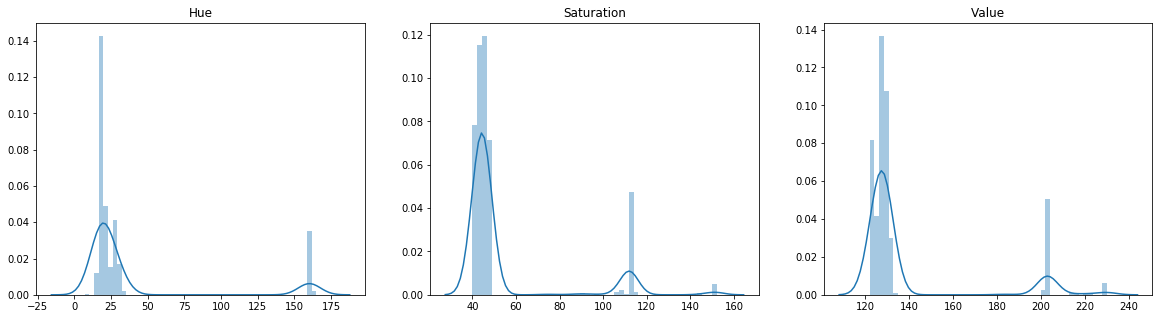

In [43]:
plot_ch(crop_img)

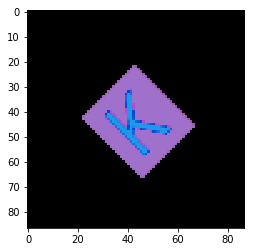

In [44]:
shp_n_char = mask & crop
plt.imshow(shp_n_char)

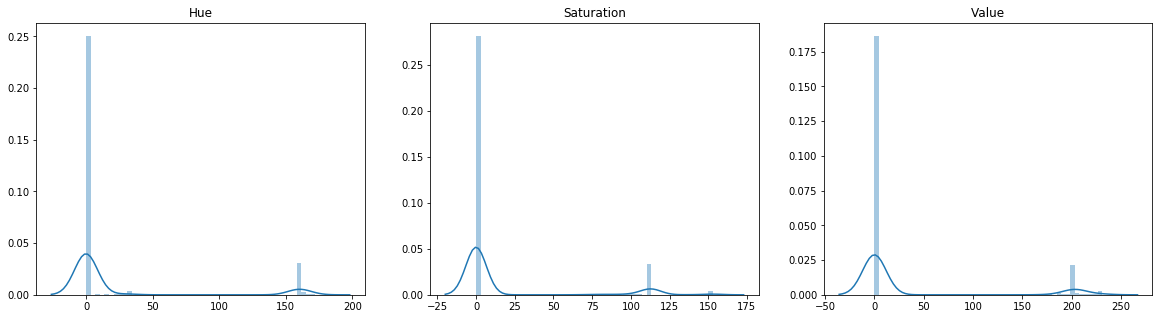

In [45]:
plot_ch(shp_n_char)

#### Shape Color is majority, Letter color is minority
***Assumes area of shape is greater than area of letter

#### Letter Classification:
get binary image mask from thresholding hsv based on above analysis
run through cnn

#### Shape Classification:
??? Hough Transform + KNN?

In [41]:
shp_n_char.shape

(87, 87, 3)

In [42]:
def get_objective_shapes(img, hue):
    """ Use hue cutoff to get masks of the shao"""
    
    if (hue[0] < hue[1]): # Shape's hue value is less than Letter's
        shape_mask = cv2.inRange(img,(1,1,1),(np.mean(hue),255,255))
        
        letter_mask = cv2.inRange(img,(np.mean(hue),0,0),(255,255,255))
    else:
        shape_mask = cv2.inRange(img,(np.mean(hue),0,0),(255,255,255))
        letter_mask = cv2.inRange(img,(1,1,1),(np.mean(hue),255,255))
        
    shape_mask = cv2.cvtColor(shape_mask,cv2.COLOR_GRAY2BGR)      #Turn mask into 3D array
    letter_mask = cv2.cvtColor(letter_mask,cv2.COLOR_GRAY2BGR) 
    
    shape = img & shape_mask
    letter = img & letter_mask
    return shape, letter

thresh = find_threshhold(shp_n_char)
hue = thresh[0]


shape, letter = get_objective_shapes(shp_n_char, hue)

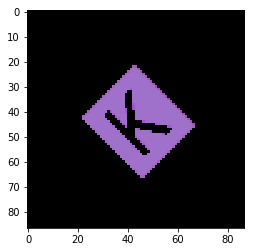

In [43]:
plt.imshow(shape)

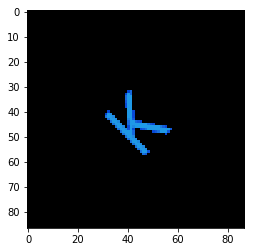

In [44]:
plt.imshow(letter)

# 2.Something Color

In [49]:
from sklearn.cluster import KMeans

In [52]:
color_data = np.reshape(shp_n_char, (-1, 3))

In [54]:
clf = KMeans(n_clusters=3, )
clf.fit(color_data)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [55]:
clf.cluster_centers_

array([[ 1.96820338e-12,  1.35358391e-12, -1.37845291e-12],
       [ 1.60511758e+02,  1.10231803e+02,  2.01617021e+02],
       [ 2.60125000e+01,  1.30181250e+02,  2.25537500e+02]])

In [65]:
classes = clf.predict(color_data)

In [72]:
np.where(classes == 3)

(array([], dtype=int64),)

# 2. Detecting Alphanumerics + Orientation
X - Use Tesseract (OCR) Software (SCRAP)

Train CNN

## 2.1 Classify

Use binary image as input into a trained CNN (Not included in the notebook yet)

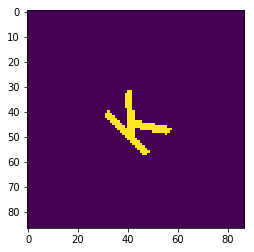

In [45]:
bi_letter = np.clip(cv2.cvtColor(letter, cv2.COLOR_RGB2GRAY),0,1);
plt.imshow(bi_letter)

## 2.2 Color

In [46]:
def find_common_colors(rgb):
    """ Return the RGB values of the second highest frequency color (other than (0,0,0))"""
    
    def find_mean_dist(ch):
        """ Find the distribution of pixel frequencies and find distribution means"""
        channel = rgb[:,:,ch]
        unique, cnt = np.unique(channel, return_counts=True)
        args = cnt.argsort()[-2:][::-1]
        return unique[args]
        
#         counts[]
    
    r = find_mean_dist(0)[1]
    g = find_mean_dist(1)[1]
    b = find_mean_dist(2)[1]

    return (r,g,b)

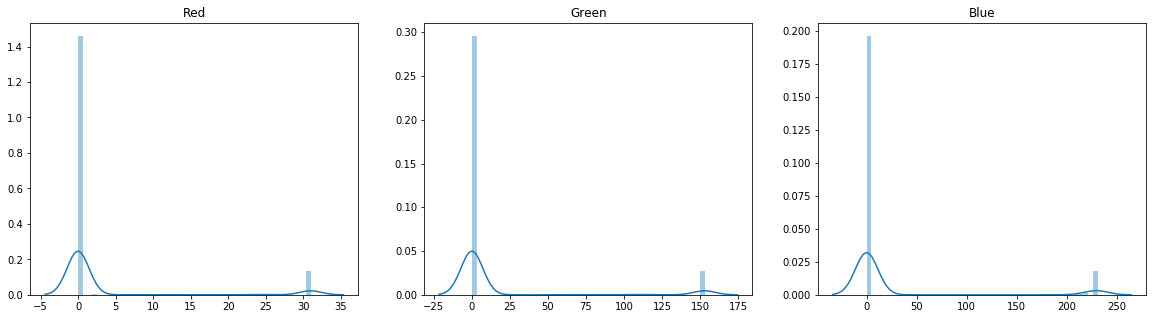

In [47]:
kernel = np.ones((5,5),np.uint8)
filled_letter = cv2.dilate(letter,kernel,iterations = 2)
plot_ch(filled_letter, titles = ['Red','Green','Blue'])

Actual Color: [31, 153, 231]
Calculated Color: (31, 153, 231)


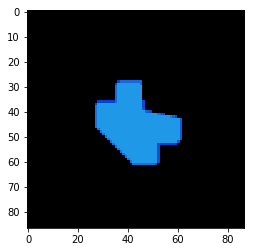

In [48]:
print("Actual Color: {}".format(list(filled_letter[40,40]))) ### Actual Color
print("Calculated Color: {}".format(find_common_colors(letter)))

plt.imshow(filled_letter);

# 3. Shapes

## 3.1 Actual Shape 
1) Fill in hole created by letter

2) Convert image to binary

3) Classify based on edges

In [293]:
def get_shape(img):
    """ Return shape given binary image"""
    _, contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    word = ""

    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
        if len(approx) == 3:
            word = "Triangle"
        elif len(approx) == 4:
            word = "Rectangle"
        elif len(approx) == 5:
            word = "Pentagon"
        elif 6 < len(approx) < 15:
            word = "Elipse"
        else:
            word= "Circle"

    return word

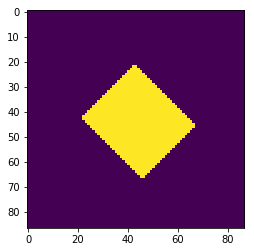

In [294]:
filled_shape = cv2.morphologyEx(shape, cv2.MORPH_CLOSE, kernel)           # 1) Fill in hole created by letter
bi_shape = np.clip(cv2.cvtColor(filled_shape, cv2.COLOR_RGB2GRAY),0,1);   # 2) Convert image to binary

plt.imshow(bi_shape);

In [295]:
get_shape(bi_shape)     # 3) Classify based on edges

'Rectangle'

## 3.2 Color

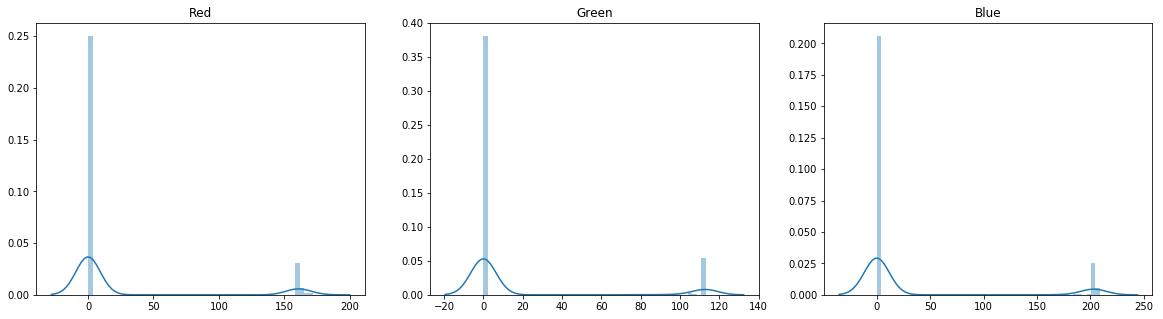

In [296]:
plot_ch(filled_shape, titles = ['Red','Green','Blue'])

Actual Color: [160, 113, 203]
Calculated Color: (160, 113, 203)


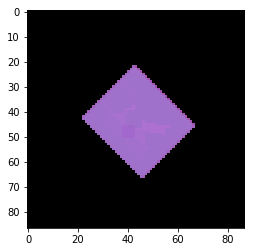

In [297]:
print("Actual Color: {}".format(list(filled_shape[45,30]))) ### Actual Color
print("Calculated Color: {}".format(find_common_colors(filled_shape)))

plt.imshow(filled_shape);

In [298]:
from sklearn.neighbors import KNeighborsClassifier

In [300]:
colors = {'white': np.array([(255,255,255),(255,250,250),(255,255,240)]),
            'black': np.array([(0,0,0)]),
            'gray': np.array([(211,211,211),(192,192,192),(169,169,169),(128,128,128),(105,105,105),(119,136,153),(112,128,144)]),
            'red': np.array([(255,160,122),(250,128,114),(233,150,122),(240,128,128),(205,92,92),(220,20,60),(178,34,34),(255,0,0),(139,0,0),(128,0,0),(255,99,71),(255,69,0),(219,112,147)]),
            'blue': np.array([(176,224,230),(173,216,230),(135,206,250),(135,206,235),(0,191,255),(176,196,222),(30,144,255),(100,149,237),(70,130,180),(95,158,160),(123,104,238),(106,90,205),(72,61,139),(65,105,225),(0,0,255),(0,0,205),(0,0,139),(0,0,128),(25,25,112)]),
            'green': np.array([(124,252,0),(127,255,0),(50,205,50),(0,255,0),(34,139,34),(0,128,0),(0,100,0),(173,255,47),(154,205,50),(0,255,127),(0,250,154),(144,238,144),(152,251,152),(143,188,143),(60,179,113),(32,178,170),(46,139,87),(128,128,0),(85,107,47),(107,142,35)]),
            'yellow': np.array([(255,250,205),(250,250,210),(255,239,213),(255,228,181),(255,218,185),(238,232,170),(240,230,140),(189,183,107),(255,255,0)]),
            'purple': np.array([(147,112,219),(238,130,238),(218,112,214),(255,0,255),(186,85,211),(138,43,226),(148,0,211),(153,50,204),(139,0,139),(128,0,128),(75,0,130)]),
            'brown': np.array([(255,248,220),(255,235,205),(255,228,196),(255,222,173),(245,222,179),(222,184,135),(210,180,140),(188,143,143),(244,164,96),(218,165,32),(205,133,63),(210,105,30),(139,69,19),(160,82,45),(165,42,42),(128,0,0)]),
            'orange': np.array([(255,127,80),(255,99,71),(255,165,0),(255,140,0)])}

In [301]:
neigh = KNeighborsClassifier(n_neighbors=1)
color_X = np.array([colors[x] for x in colors.keys()])
color_y = np.array([np.repeat(key, len(colors[key])) for key in colors.keys()])
color_X = np.concatenate(color_X)
color_y = np.concatenate(color_y)
len(color_y) == len(color_X)
neigh.fit(color_X, color_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [302]:
print(color_y)

['white' 'white' 'white' 'black' 'gray' 'gray' 'gray' 'gray' 'gray' 'gray'
 'gray' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue'
 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue' 'blue'
 'blue' 'green' 'green' 'green' 'green' 'green' 'green' 'green' 'green'
 'green' 'green' 'green' 'green' 'green' 'green' 'green' 'green' 'green'
 'green' 'green' 'green' 'yellow' 'yellow' 'yellow' 'yellow' 'yellow'
 'yellow' 'yellow' 'yellow' 'yellow' 'purple' 'purple' 'purple' 'purple'
 'purple' 'purple' 'purple' 'purple' 'purple' 'purple' 'purple' 'brown'
 'brown' 'brown' 'brown' 'brown' 'brown' 'brown' 'brown' 'brown' 'brown'
 'brown' 'brown' 'brown' 'brown' 'brown' 'brown' 'orange' 'orange'
 'orange' 'orange']


In [305]:
color_test = filled_shape[45,30][:,None].T
color_test

array([[160, 113, 203]], dtype=uint8)

In [306]:
neigh.predict(color_test)

array(['purple'], dtype='<U6')

# Orientation
N, NE, E, SE, S,etc...

* Train CNN on 45 degree rotations. Classify on all and take most likely based on probabilistic posterior

* Works only if camera is constantly aligned

Image stitching? for gps coordinates